# Feed-Forward Autoencoder Implementation on the Fashion MNIST Dataset

### 1. Imports

In [53]:
# Imports 
import os 

import numpy as np 

import torch
from torchvision.datasets import FashionMNIST
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

import matplotlib.pyplot as plt

from tqdm import tqdm, trange

import seaborn as sns

#Applying the default theme for matplotlib (Just to make it look cooler!)
sns.set_theme()
#sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
# Checking for CUDA device (Training on the GPU is faster)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU available and ready to use")
else:
    device = torch.device("cpu")
    print("GPU not available, using the CPU instead")

GPU available and ready to use


### 2. Loading the dataset

In [3]:
# downloading the dataset

datapath = ".\data\FasionMNIST"  # Path of the downloaded (or to download) data

# Check if data is already downloaded, if it is just load it, otherwise fetch it
if os.path.isdir(datapath):
    Train_dataset = FashionMNIST(root = datapath + "\Train", download = False)
    Test_dataset = FashionMNIST(root = datapath + "\Test", train = False, download = False)
else:
    Train_dataset = FashionMNIST(root = datapath + "\Train", download = True)
    Test_dataset = FashionMNIST(root = datapath + "\Test", train = False, download = True)

# 3. Preprocessing the dataset

In [4]:
# First, the datapoints need to be transformed to tensors#
Train = []
Test = []

for x, y in Train_dataset:
    # flattening the images (with .reshape) so they're compatible with a FFNN (Feed forward neural network)
    Train.append(np.array(x,dtype= np.float32).reshape(784)/256) # Dividing by 256 to normalize the pixel values
for x, y in Test_dataset:
    # The datatype needs to be float32 (double)
    Test.append(np.array(x,dtype= np.float32).reshape(784)/256)
    
# The two lists need to be converted to tensors so they're compatible with the PyTorch model

Train = torch.as_tensor(np.array(Train), dtype = torch.float32, device = device)
Test = torch.as_tensor(np.array(Test), dtype = torch.float32, device = device)

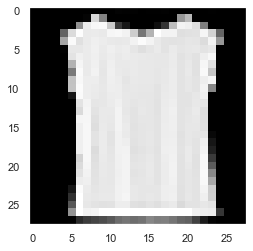

In [59]:
# Showing one datapoint as an example
# In order to print the picture to the screen it needs some preprocessing first:
    # - The picture gets reshaped back to 28x28 pixels
    # - If the tensor is on the GPU it needs to be sent back to the CPU via the command .cpu()
 
plt.grid(b=None) # Setting the grid off 
plt.imshow(Train[499].reshape(28,28).cpu(), cmap="gray") 

### 4. Creating the model's architecture

In [22]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # The encoder part of the architecture
        self.encoder = nn.Sequential(
                            nn.Linear(784,300),
                            nn.ReLU(True),
                            nn.Linear(300,150),
                            nn.ReLU(True),
                            nn.Linear(150,25),
                            nn.ReLU(True),
                            nn.Linear(25,15),
                            nn.ReLU(True),
                        )
        
        # The decoder part of the architecture
        self.decoder = nn.Sequential(
                            nn.Linear(15,25),
                            nn.ReLU(True),
                            nn.Linear(25,150),
                            nn.ReLU(True),
                            nn.Linear(150,300),
                            nn.ReLU(True),
                            nn.Linear(300,784),
                            nn.ReLU(True),
                        )
    
    # Forward pass
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
        

### 5. Training the model 

In [23]:
# Instantiate the architecture (The .to(device) instruction moves the model object to the memory of the device being used)
model =  AutoEncoder().to(device)

# Printing the model's architecture
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=300, out_features=150, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=150, out_features=25, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=25, out_features=15, bias=True)
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=25, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=25, out_features=150, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=150, out_features=300, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=300, out_features=784, bias=True)
    (7): ReLU(inplace=True)
  )
)


In [30]:
# Instantiate the loss function and optimizer
loss_function = nn.MSELoss()  # Mean square error loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer

In [31]:
 

nEpochs = 1000  # Number of epochs

Losses = []  # Array that keeps track of the model's loss over the epochs

# Training loop
for epoch in (t := trange(nEpochs)): 
    
    # Zero the gradients of the optimizer
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(Train)
    
    # Calculate loss
    loss = loss_function(outputs,Train)
    
    # Backward pass
    loss.backward()
    
    # Optimizer step
    optimizer.step()
    
    # Appending the loss of the current epoch to the Losses array
    Losses.append(loss.item())
    
    t.set_description("Loss = " + str(loss.item()))

Loss = 0.029176829382777214: 100%|█████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.74it/s]


### 6. Training metrics 

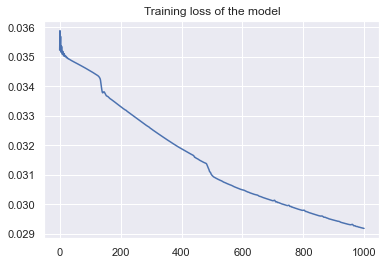

In [56]:
# Plotting the Training loss 
plt.title("Training loss of the model")
plt.plot(Losses)

### 7. Save/Load the model

### 8. Testing

### 9. Visualizing reconstructed images

<Figure size 432x288 with 0 Axes>

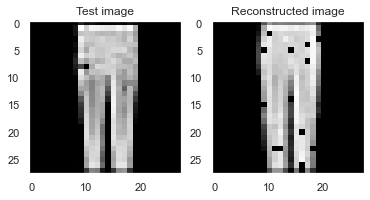

In [57]:
InputIndex = 200 # Index of the test image to show

# Set to eval mode for inference and get the reconstructed image
model.eval()
reconstructed = model(Test[InputIndex]).cpu().detach().numpy()

# Create the figure to plot the images
plt.figure()
f, ax = plt.subplots(1,2) # Create two subplots for the two images

# Test image
ax[0].title.set_text("Test image") 
ax[0].grid(False) # Setting the seaborn grid to false 
ax[0].imshow(Test[InputIndex].reshape(28,28).cpu(), cmap="gray")

# Reconstructed Image 
ax[1].title.set_text("Reconstructed image")
ax[1].grid(False) # Setting the seaborn grid to false 
ax[1].imshow(reconstructed.reshape(28,28), cmap="gray") 